# TA2 - CNNs on FashionMNIST

- simple CNN architecture
- Optuna tuning
- direct training/evaluation
- no persistence logic during training (that is, if our run gets cancelled halfway, we have to start over from scratch)

## Imports and Setup

In [55]:
import os
import time
import random
from pathlib import Path
from typing import Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchinfo import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import optuna

from plot_utils import plot_random_raw_samples, plot_one_per_class

In [56]:
# Set the random seed for reproducibility
# np.random.seed() has a range of [0, 2**32 - 1] for the seed value
# print(np.random.randint(0, 2**32 - 1))  # Uncomment here for the first run to be a statistical purist
SEED = 1129775555  # Obviously your print is going to be something different

In [57]:
if torch.backends.mps.is_built() and torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print(f'Using device: {DEVICE}')


Using device: mps


Is everyone clear on relative vs absolute paths? If not, do ask!

A short guide if you are using Jupyter notebooks would be to always use relative paths (that is, relative to the location of the notebook).

You only need to worry about absolute paths if you are doing more fancy settings like having a separate `src` folder for things like your model definition in a separate .py file for itself, and then you import that into your main.py file (or notebook). In that case, you do need to start worrying about absolute paths, because you can't always import functions or classes from a .py file using relative paths.

In [58]:
DATA_ROOT = Path('../data')  # FashionMNIST will be stored in ../data/FashionMNIST
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
NUM_CLASSES = len(CLASS_NAMES)
VAL_RATIO = 0.10 # Percentage of the training set to use as validation

MAX_EPOCHS = 10
FINAL_MAX_EPOCHS = 20
EARLY_STOPPING_PATIENCE = 4
N_TRIALS = 10
OPTUNA_TIMEOUT = None

"""
DATALOADER SETTINGS:
    -   num_workers determines how many subprocesses we use for data loading.
        0 means that the data will be loaded in the main process, 
        4 means that 4 CPU cores will be used to load and transform data WHILE the GPU processes the previous batch. 

    -   pin_memory can speed up data transfer to the GPU (CUDA devices ONLY).
        If True, the data loader will copy Tensors into CUDA pinned memory before returning them.

    -   AMP_ENABLED determines whether to use Automatic Mixed Precision (AMP) during training.
        AMP can speed up training on CUDA devices by using lower precision (float16) where possible, while maintaining model accuracy.
        As are other optimized settings, CUDA devices ONLY.

Remember that Tesla 4 (T4) GPUs ARE in fact CUDA devices
(as is any other GPU on Colab. Note, GPU, NOT TPU,
don't use TPUs for now, as they require some code changes that we will not be covering in this course).
"""

NUM_WORKERS = min(4, os.cpu_count() or 1)
PIN_MEMORY = (DEVICE.type == 'cuda')
AMP_ENABLED = (DEVICE.type == 'cuda')

print(f'AMP enabled: {AMP_ENABLED}')

AMP enabled: False


In [59]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(SEED)

## Data Loading and Raw Data Exploration

We inspect raw grayscale images and then build dataloaders with:
- augmentation on train only
- normalization on train/validation/test
- stratified split for class balance


In [60]:
raw_train = datasets.FashionMNIST(root=DATA_ROOT, train=True, download=True, transform=None)
raw_test = datasets.FashionMNIST(root=DATA_ROOT, train=False, download=True, transform=None)

print(f'Train size: {len(raw_train):,}')
print(f'Test size: {len(raw_test):,}')
print(f'Image shape: {raw_train[0][0].size} (grayscale)')
print(f'ACTUAL number of classes in the dataset: {len(raw_train.classes)}, vs declared number of classes: {NUM_CLASSES}')

Train size: 60,000
Test size: 10,000
Image shape: (28, 28) (grayscale)
ACTUAL number of classes in the dataset: 10, vs declared number of classes: 10


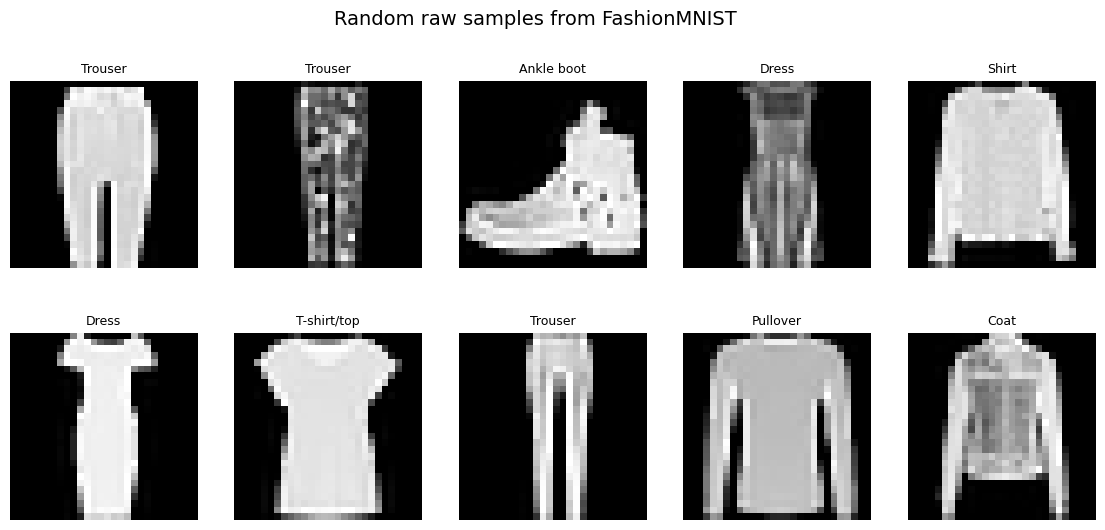

In [61]:
plot_random_raw_samples(raw_train, CLASS_NAMES, n=10, seed=SEED)

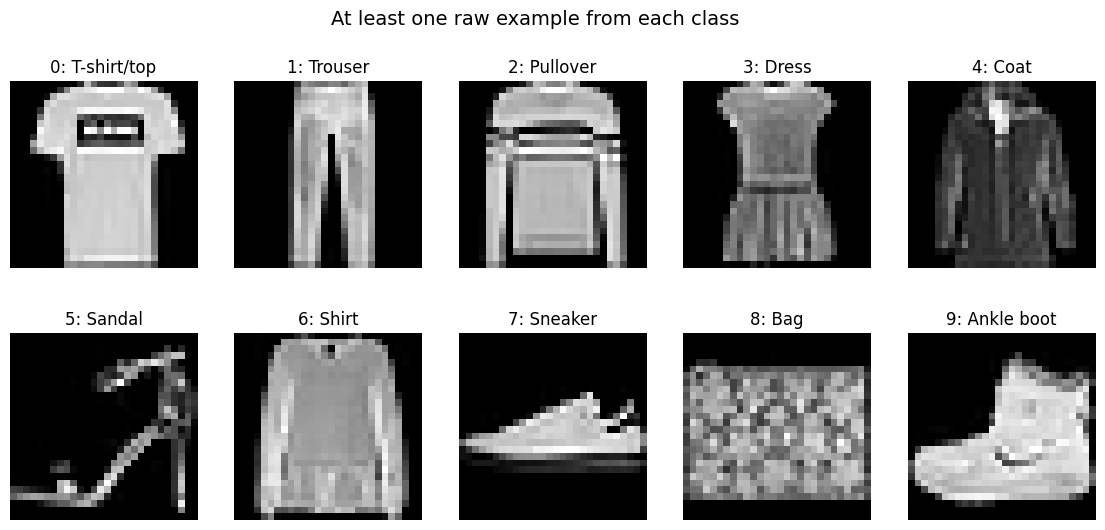

In [62]:
plot_one_per_class(raw_train, CLASS_NAMES)

If you encounter an error in the next cell, either set NUM_WORKERS = 0 or run:

```bash
chmod +x \
/Users/<youruser>/<rest of the path to the repo directory>/DL_TA_Sessions/.venv/lib/python3.12/site-packages/torch/bin/torch_shm_manager
```

This works for mac, though. If you are on windows, ask an LLM for help or just set NUM_WORKERS = 0 and accept your model will run slightly slower.

In [63]:
data_transform = transforms.Compose([
    transforms.ToTensor()
])

"""
Usually you would add some variation to the training data (data augmentation) but it is not strictly necessary for us,
and in our case it can even add unnecessary noise, harming the convergence capability of our model.

For normalization, ideally you would first load the dataset without any other transformation, compute the mean and standard deviation
manually (yeah, you need to compute them manually if needed, pixel by pixel), and then use those values on transforms.Normalize(mean, std).

You would use something like (by hand mean std for Normalization not shown here):
"""
# train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomCrop(28, padding=2),
#     transforms.ToTensor(),
#     transforms.Normalize((0.2860,), (0.3530,)),
# ])
"""
The evaluation datasets do NOT get augmented.
"""
# eval_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.2860,), (0.3530,)),
# ])

train_targets = raw_train.targets.numpy()
all_indices = np.arange(len(train_targets))
train_idx, val_idx = train_test_split(
    all_indices,
    test_size=VAL_RATIO,
    random_state=SEED,
    stratify=train_targets,
    shuffle=True,
)

train_dataset = datasets.FashionMNIST(root=DATA_ROOT, train=True, download=False, transform=data_transform)
val_dataset = datasets.FashionMNIST(root=DATA_ROOT, train=True, download=False, transform=data_transform)
test_dataset = datasets.FashionMNIST(root=DATA_ROOT, train=False, download=False, transform=data_transform)

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(val_dataset, val_idx)

print(f'Train subset size: {len(train_subset):,}')
print(f'Validation subset size: {len(val_subset):,}')
print(f'Test size: {len(test_dataset):,}')

"""
For simplicity, I set the same batch size for both train and val,
but it's very common to use a larger batch size for evaluation,
even as large as the full validation/test set if it fits in memory.
"""
def make_train_val_loaders(batch_size: int) -> tuple[DataLoader, DataLoader]:
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0),
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0),
    )
    return train_loader, val_loader


def make_test_loader(batch_size: int) -> DataLoader:
    return DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0),
    )

example_loader, _ = make_train_val_loaders(batch_size=128)
x_example, y_example = next(iter(example_loader))
print('Batch X shape:', tuple(x_example.shape))
print('Batch y shape:', tuple(y_example.shape))

Train subset size: 54,000
Validation subset size: 6,000
Test size: 10,000
Batch X shape: (128, 1, 28, 28)
Batch y shape: (128,)


In [65]:
# plot_one_per_class(train_dataset, CLASS_NAMES)

## Simple CNN Architecture

- 3 convolution blocks
- batch normalization + ReLU
- max pooling in first two blocks
- global average pooling + dropout + linear classifier


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int = 10, dropout: float = 0.3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(128, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x


def count_trainable_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model_preview = SimpleCNN(num_classes=NUM_CLASSES, dropout=0.3).to(DEVICE)
print(f'Trainable parameters: {count_trainable_parameters(model_preview):,}')
print(summary(model_preview, input_size=(1, 1, 28, 28)))
del model_preview

Trainable parameters: 94,410
Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Sequential: 1-1                        [1, 128, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           320
│    └─BatchNorm2d: 2-2                  [1, 32, 28, 28]           64
│    └─ReLU: 2-3                         [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-4                    [1, 32, 14, 14]           --
│    └─Conv2d: 2-5                       [1, 64, 14, 14]           18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 14, 14]           128
│    └─ReLU: 2-7                         [1, 64, 14, 14]           --
│    └─MaxPool2d: 2-8                    [1, 64, 7, 7]             --
│    └─Conv2d: 2-9                       [1, 128, 7, 7]            73,856
│    └─BatchNorm2d: 2-10                 [1, 128, 7, 7]            256
│    └─ReLU: 2-11                        [1, 

In [ ]:
class _DenseLayer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        growth_rate: int,
        bn_size: int = 4,
        block_dropout: float = 0.0,
    ):
        super().__init__()
        inter_channels = bn_size * growth_rate
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, inter_channels, kernel_size=1, bias=False)

        self.norm2 = nn.BatchNorm2d(inter_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(inter_channels, growth_rate, kernel_size=3, padding=1, bias=False)

        self.block_dropout = block_dropout

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv1(self.relu1(self.norm1(x)))
        out = self.conv2(self.relu2(self.norm2(out)))
        if self.block_dropout > 0.0:
            out = nn.functional.dropout(out, p=self.block_dropout, training=self.training)
        return torch.cat([x, out], dim=1)


class _DenseBlock(nn.Module):
    def __init__(
        self,
        num_layers: int,
        in_channels: int,
        growth_rate: int,
        bn_size: int = 4,
        block_dropout: float = 0.0,
    ):
        super().__init__()
        layers = []
        channels = in_channels
        for _ in range(num_layers):
            layer = _DenseLayer(
                in_channels=channels,
                growth_rate=growth_rate,
                bn_size=bn_size,
                block_dropout=block_dropout,
            )
            layers.append(layer)
            channels += growth_rate
        self.block = nn.Sequential(*layers)
        self.out_channels = channels

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class _Transition(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class DenseNet(nn.Module):
    def __init__(
        self,
        num_classes: int = 10,
        dropout: float = 0.2,
        dense_blocks: int = 4,
        layers_per_block: int = 4,
        growth_rate: int = 16,
        init_features: int = 32,
        bn_size: int = 4,
        block_dropout: float = 0.1,
        compression: float = 0.5,
    ):
        super().__init__()

        if not isinstance(dense_blocks, int) or dense_blocks < 2:
            raise ValueError('dense_blocks must be an integer >= 2.')
        if not isinstance(layers_per_block, int) or layers_per_block < 1:
            raise ValueError('layers_per_block must be an integer >= 1.')
        if not (0.0 < compression <= 1.0):
            raise ValueError('compression must be in (0, 1].')

        block_config = [layers_per_block] * dense_blocks

        self.stem = nn.Sequential(
            nn.Conv2d(1, init_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(init_features),
            nn.ReLU(inplace=True),
        )

        channels = init_features
        features = []
        for block_idx, num_layers in enumerate(block_config):
            dense_block = _DenseBlock(
                num_layers=num_layers,
                in_channels=channels,
                growth_rate=growth_rate,
                bn_size=bn_size,
                block_dropout=block_dropout,
            )
            features.append(dense_block)
            channels = dense_block.out_channels

            if block_idx < len(block_config) - 1:
                out_channels = max(8, int(channels * compression))
                transition = _Transition(in_channels=channels, out_channels=out_channels)
                features.append(transition)
                channels = out_channels

        self.features = nn.Sequential(*features)
        self.head = nn.Sequential(
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(channels, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.stem(x)
        x = self.features(x)
        x = self.head(x)
        return x


Layer (type:depth-idx)                        Output Shape              Param #
DenseNet                                      [1, 10]                   --
├─Sequential: 1-1                             [1, 32, 28, 28]           --
│    └─Conv2d: 2-1                            [1, 32, 28, 28]           288
│    └─BatchNorm2d: 2-2                       [1, 32, 28, 28]           64
│    └─ReLU: 2-3                              [1, 32, 28, 28]           --
├─Sequential: 1-2                             [1, 124, 3, 3]            --
│    └─_DenseBlock: 2-4                       [1, 96, 28, 28]           --
│    │    └─Sequential: 3-1                   [1, 96, 28, 28]           52,160
│    └─_Transition: 2-5                       [1, 48, 14, 14]           --
│    │    └─Sequential: 3-2                   [1, 48, 14, 14]           4,800
│    └─_DenseBlock: 2-6                       [1, 112, 14, 14]          --
│    │    └─Sequential: 3-3                   [1, 112, 14, 14]          56,384
│    └─_

In [ ]:
def compute_epoch_metrics(y_true: list[int], y_pred: list[int]) -> dict[str, float]:
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'macro_f1': f1_score(y_true, y_pred, average='macro'),
    }


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    scaler: torch.amp.GradScaler,
) -> dict[str, float]:
    model.train()
    losses = []
    all_true, all_pred = [], []

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True) # non_blocking=True allows the data transfer to overlap with other operations
        y = y.to(DEVICE, non_blocking=True) # but it only works if device='cuda' and pin_memory=True

        optimizer.zero_grad() 

        if AMP_ENABLED:
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        all_true.extend(y.detach().cpu().tolist())
        all_pred.extend(torch.argmax(logits.detach(), dim=1).cpu().tolist())

    metrics = compute_epoch_metrics(all_true, all_pred)
    metrics['loss'] = float(np.mean(losses))
    return metrics


@torch.no_grad()
def evaluate_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
) -> tuple[dict[str, float], list[int], list[int]]:
    model.eval()
    losses = []
    all_true, all_pred = [], []

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        if AMP_ENABLED:
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(x)
                loss = criterion(logits, y)
        else:
            logits = model(x)
            loss = criterion(logits, y)

        losses.append(loss.item())
        all_true.extend(y.detach().cpu().tolist())
        all_pred.extend(torch.argmax(logits.detach(), dim=1).cpu().tolist())

    metrics = compute_epoch_metrics(all_true, all_pred)
    metrics['loss'] = float(np.mean(losses))
    return metrics, all_true, all_pred


In [ ]:
def run_training(
    params: dict[str, Any],
    train_loader: DataLoader,
    val_loader: DataLoader,
    max_epochs: int,
    trial: optuna.trial.Trial | None = None,
) -> dict[str, Any]:
    model = SimpleCNN(num_classes=NUM_CLASSES, dropout=params['dropout']).to(DEVICE)
    criterion = nn.CrossEntropyLoss(label_smoothing=params['label_smoothing'])
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=params['lr'],
        weight_decay=params['weight_decay'],
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=max_epochs,
        eta_min=1e-6,
    )
    scaler = torch.amp.GradScaler('cuda', enabled=AMP_ENABLED)

    best_val_score = -1.0
    best_state_dict = None
    epochs_without_improvement = 0
    history_rows: list[dict[str, float]] = []

    for epoch in range(max_epochs):
        train_metrics = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
        val_metrics, _, _ = evaluate_one_epoch(model, val_loader, criterion)
        scheduler.step()

        row = {
            'epoch': epoch,
            'train_loss': train_metrics['loss'],
            'train_accuracy': train_metrics['accuracy'],
            'train_macro_f1': train_metrics['macro_f1'],
            'val_loss': val_metrics['loss'],
            'val_accuracy': val_metrics['accuracy'],
            'val_macro_f1': val_metrics['macro_f1'],
            'lr': float(optimizer.param_groups[0]['lr']),
        }
        history_rows.append(row)

        val_score = val_metrics['accuracy']
        if val_score > (best_val_score + 1e-4):
            best_val_score = val_score
            best_state_dict = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if trial is not None:
            trial.report(val_score, step=epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned(f'Pruned at epoch {epoch}')

        if epochs_without_improvement > EARLY_STOPPING_PATIENCE:
            break

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        model = model.to(DEVICE)

    return {
        'model': model,
        'history_df': pd.DataFrame(history_rows),
        'best_val_score': float(best_val_score),
        'epochs_ran': int(len(history_rows)),
    }


## Hyperparameter Tuning with Optuna

We tune:
- learning rate
- weight decay
- dropout
- label smoothing
- batch size

Optimization target: **validation accuracy**.


In [ ]:
def suggest_params(trial: optuna.trial.Trial) -> dict[str, Any]:
    return {
        'lr': trial.suggest_float('lr', 1e-5, 5e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 5e-3, log=True),
        'dropout': trial.suggest_float('dropout', 0.10, 0.50),
        'label_smoothing': trial.suggest_float('label_smoothing', 0.0, 0.12),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
    }

def suggest_params_dense(trial: optuna.trial.Trial) -> dict[str, Any]:
    params = suggest_params(trial)
    params.update({
        'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
        'dropout': trial.suggest_float('dropout', 0.10, 0.30),
        'label_smoothing': trial.suggest_float('label_smoothing', 0.0, 0.10),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
        'dense_blocks': trial.suggest_int('dense_blocks', 2, 4),
        'layers_per_block': trial.suggest_int('layers_per_block', 2, 6),
        'growth_rate': trial.suggest_categorical('growth_rate', [8, 16, 32]),
        'init_features': trial.suggest_categorical('init_features', [16, 32, 64]),
        'bn_size': trial.suggest_int('bn_size', 2, 6),
        'block_dropout': trial.suggest_float('block_dropout', 0.0, 0.3),
        'compression': trial.suggest_float('compression', 0.5, 1.0),
    })
    return params

def objective(trial: optuna.trial.Trial) -> float:
    params = suggest_params(trial)
    train_loader, val_loader = make_train_val_loaders(batch_size=params['batch_size'])

    result = run_training(
        params=params,
        train_loader=train_loader,
        val_loader=val_loader,
        max_epochs=MAX_EPOCHS,
        trial=trial,
    )
    trial.set_user_attr('epochs_ran', result['epochs_ran'])
    return result['best_val_score']


In [ ]:
sampler = optuna.samplers.TPESampler(seed=SEED)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3)
study = optuna.create_study(
    study_name='ta2_cnns_benchmark',
    direction='maximize',
    sampler=sampler,
    pruner=pruner,
)

start_time = time.perf_counter()
study.optimize(objective, n_trials=N_TRIALS, timeout=OPTUNA_TIMEOUT, show_progress_bar=True)
search_minutes = (time.perf_counter() - start_time) / 60

print(f'Finished {len(study.trials)} trials in {search_minutes:.2f} minutes.')
print('Best validation score:', round(study.best_value, 4))
print('Best params:', study.best_params)


[I 2026-02-27 01:20:52,471] A new study created in memory with name: ta2_cnns_benchmark


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-02-27 01:21:40,980] Trial 0 finished with value: 0.9093333333333333 and parameters: {'lr': 0.0009799880789689867, 'weight_decay': 0.0010252325657356116, 'dropout': 0.49452002158405994, 'label_smoothing': 0.05062182597652044, 'batch_size': 64}. Best is trial 0 with value: 0.9093333333333333.
[I 2026-02-27 01:22:01,923] Trial 1 finished with value: 0.8793333333333333 and parameters: {'lr': 0.00029508867536450433, 'weight_decay': 4.3068143736732384e-05, 'dropout': 0.32127934726819773, 'label_smoothing': 0.00862312487702463, 'batch_size': 256}. Best is trial 0 with value: 0.9093333333333333.
[I 2026-02-27 01:22:50,421] Trial 2 finished with value: 0.8755 and parameters: {'lr': 0.0001278057023579824, 'weight_decay': 3.827097445542683e-06, 'dropout': 0.3870058602180848, 'label_smoothing': 0.07250260535688742, 'batch_size': 64}. Best is trial 0 with value: 0.9093333333333333.
[I 2026-02-27 01:23:19,792] Trial 3 finished with value: 0.9256666666666666 and parameters: {'lr': 0.011056125

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_label_smoothing,params_lr,params_weight_decay,user_attrs_epochs_ran,state
3,3,0.925667,2026-02-27 01:22:50.422965,2026-02-27 01:23:19.792082,0 days 00:00:29.369117,128,0.140557,0.083165,0.011056,0.004928,10.0,COMPLETE
6,6,0.925333,2026-02-27 01:24:19.284088,2026-02-27 01:24:39.518240,0 days 00:00:20.234152,256,0.147159,0.054928,0.016439,0.000038,10.0,COMPLETE
9,9,0.921833,2026-02-27 01:25:01.580338,2026-02-27 01:25:29.883421,0 days 00:00:28.303083,128,0.127786,0.025284,0.003193,0.000540,10.0,COMPLETE
0,0,0.909333,2026-02-27 01:20:52.476052,2026-02-27 01:21:40.980073,0 days 00:00:48.504021,64,0.494520,0.050622,0.000980,0.001025,10.0,COMPLETE
1,1,0.879333,2026-02-27 01:21:40.981802,2026-02-27 01:22:01.923247,0 days 00:00:20.941445,256,0.321279,0.008623,0.000295,0.000043,10.0,COMPLETE
2,2,0.875500,2026-02-27 01:22:01.924968,2026-02-27 01:22:50.421501,0 days 00:00:48.496533,64,0.387006,0.072503,0.000128,0.000004,10.0,COMPLETE
7,7,0.857833,2026-02-27 01:24:39.519867,2026-02-27 01:24:50.277729,0 days 00:00:10.757862,256,0.377640,0.087627,0.000413,0.000016,NaN,PRUNED
5,5,0.857167,2026-02-27 01:24:08.528625,2026-02-27 01:24:19.282291,0 days 00:00:10.753666,256,0.316625,0.112845,0.001009,0.000198,NaN,PRUNED
4,4,0.856833,2026-02-27 01:23:19.793770,2026-02-27 01:24:08.526937,0 days 00:00:48.733167,64,0.485801,0.022837,0.000078,0.001678,10.0,COMPLETE
8,8,0.807167,2026-02-27 01:24:50.279492,2026-02-27 01:25:01.578540,0 days 00:00:11.299048,256,0.303694,0.066241,0.000097,0.000050,NaN,PRUNED


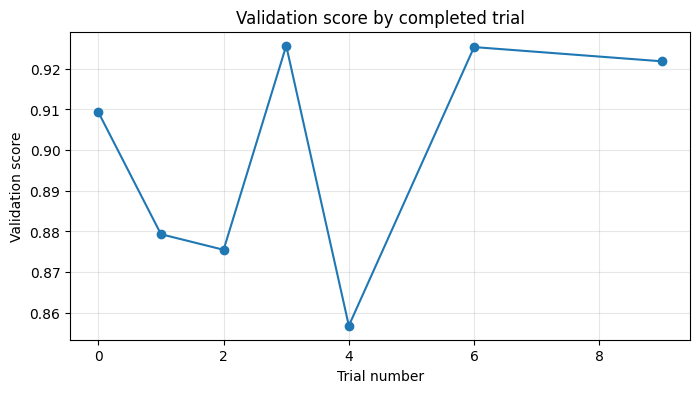

In [ ]:
trials_df = study.trials_dataframe()
display(trials_df.sort_values('value', ascending=False).head(10))

plt.figure(figsize=(8, 4))
completed = trials_df[trials_df['state'] == 'COMPLETE']
plt.plot(completed['number'], completed['value'], marker='o')
plt.title('Validation score by completed trial')
plt.xlabel('Trial number')
plt.ylabel('Validation score')
plt.grid(True, alpha=0.3)
plt.show()


## Final Training and Out-of-Sample Evaluation

After tuning, we retrain with the best hyperparameters and evaluate on the held-out 10k test set.

Metrics:
- test loss
- test accuracy
- test Macro-F1
- per-class report
- confusion matrix


In [ ]:
best_params = study.best_trial.params.copy()
train_loader, val_loader = make_train_val_loaders(batch_size=best_params['batch_size'])

start_time = time.perf_counter()
final_result = run_training(
    params=best_params,
    train_loader=train_loader,
    val_loader=val_loader,
    max_epochs=FINAL_MAX_EPOCHS,
    trial=None,
)
final_minutes = (time.perf_counter() - start_time) / 60

best_model = final_result['model'].to(DEVICE)
print(f'Final training finished in {final_minutes:.2f} minutes')
print('Best validation score:', round(final_result['best_val_score'], 4))
print('Epochs used:', final_result['epochs_ran'])


Final training finished in 0.82 minutes
Best validation score: 0.9337
Epochs used: 20


In [ ]:
criterion_eval = nn.CrossEntropyLoss()
test_loader = make_test_loader(batch_size=best_params['batch_size'])
test_metrics, y_true_test, y_pred_test = evaluate_one_epoch(best_model, test_loader, criterion_eval)

print('Test metrics (out-of-sample):')
print(f"  Loss:      {test_metrics['loss']:.4f}")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  Macro-F1:  {test_metrics['macro_f1']:.4f}")

print('\nPer-class report:')
print(classification_report(y_true_test, y_pred_test, target_names=CLASS_NAMES, digits=4))

Test metrics (out-of-sample):
  Loss:      0.2659
  Accuracy:  0.9331
  Macro-F1:  0.9329

Per-class report:
              precision    recall  f1-score   support

 T-shirt/top     0.8801    0.9030    0.8914      1000
     Trouser     0.9929    0.9850    0.9890      1000
    Pullover     0.9081    0.8990    0.9035      1000
       Dress     0.9348    0.9320    0.9334      1000
        Coat     0.8839    0.9140    0.8987      1000
      Sandal     0.9879    0.9810    0.9844      1000
       Shirt     0.8130    0.7780    0.7951      1000
     Sneaker     0.9581    0.9840    0.9709      1000
         Bag     0.9880    0.9890    0.9885      1000
  Ankle boot     0.9827    0.9660    0.9743      1000

    accuracy                         0.9331     10000
   macro avg     0.9330    0.9331    0.9329     10000
weighted avg     0.9330    0.9331    0.9329     10000



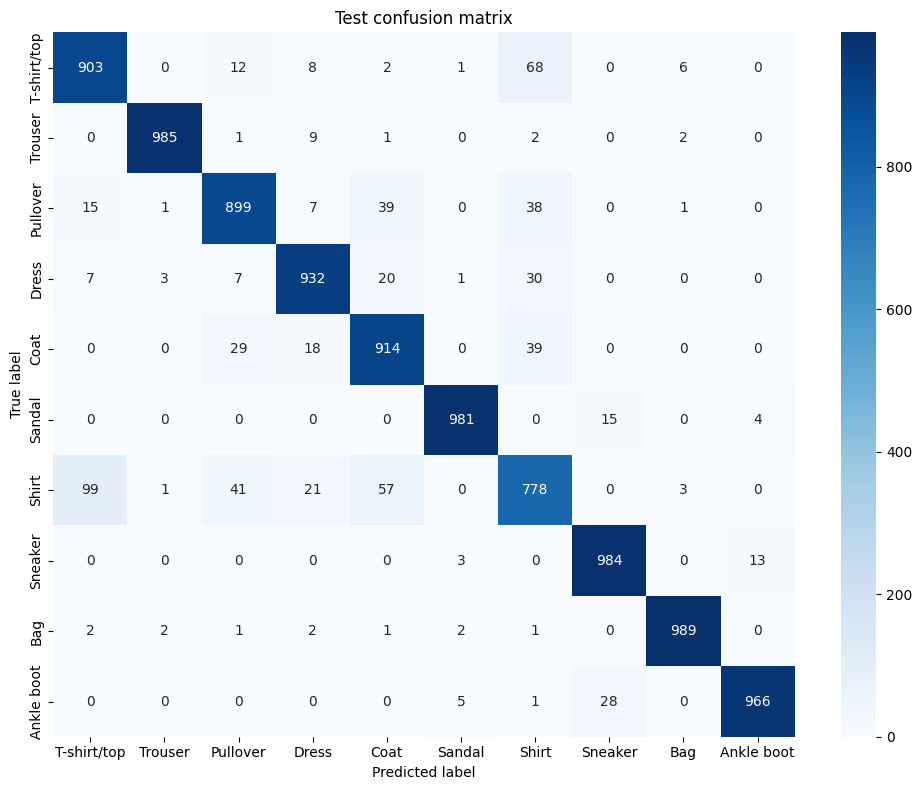

In [ ]:
cm = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
)
plt.title('Test confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()